# Towards a parsimonious model for predicting housing prices

AKA How to re-learn how to apply statistics in Python, followed by Machine learning

In [2]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load in the dataset
data_dir = "~/CloudStation/CS-scratchpad/kaggle-datasets/house-prices-tutorial"
ds = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col="Id")

In [4]:
print(ds.shape)
ds.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Let's look at what we're trying to predict
ds["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

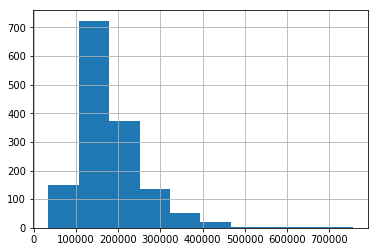

In [6]:
ds["SalePrice"].hist()

First thing to notice, it might be log-normal distributed. Let's have a look. This could be useful later-- just something to note.

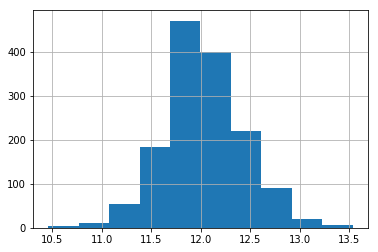

In [8]:
ds["SalePrice"].apply(np.log).hist()

Let's clean the data a little bit. Specifically, we'll remove the columns that have nearly all of the data missing

In [9]:
# missing values
total = ds.isnull().sum().sort_values(ascending=False)
total = total[total > 0]
percent = total/len(ds)
missing_df = pd.concat([total, percent], axis=1, keys = ["missing", "percent"])



In [10]:
droplist = missing_df[missing_df["percent"] > .5].index
ds_dropped = ds.drop(droplist, axis=1)
ds_dropped.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


## Did sale type influence sale price?

AKA Running exploratory statistics using python. There are a number of "conditions", i.e. the different types of sales, all presumably having an effect on sale price (ignoring the contribution of all other factors). This is a simple one-way f-test, after which we will go in to see the driving factors.

In [44]:
# Which sale type had the highest mean sale? The lowest?
(ds_dropped
 .groupby("SaleType")
 .mean()
 .sort_values("SalePrice", ascending=False)
 .index[[0, -1]]
)


Index(['New', 'Oth'], dtype='object', name='SaleType')

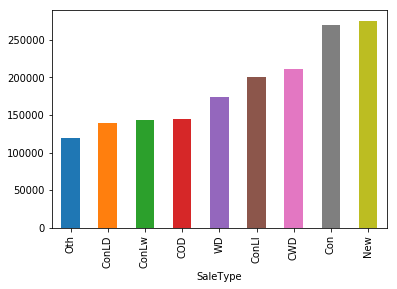

In [52]:
(ds_dropped
 .groupby("SaleType")
 .mean()
 .sort_values("SalePrice")["SalePrice"]
 .plot(kind="bar"))

# (ds_dropped
#  .groupby("SaleType")["SalePrice"]
#  .mean()
#  .sort_values()
#  .plot(kind="bar"))

In [14]:
from scipy.stats import f_oneway
# for st in df.groupby("SaleType"):
samples = [st[1] for st in ds_dropped.groupby("SaleType")["SalePrice"]]
f_result = f_oneway(*samples)
print(f_result)
# yes, the means are definitely different. but which ones?

F_onewayResult(statistic=28.863054116984085, pvalue=5.039766889462451e-42)


group1,group2,meandiff,lower,upper,reject
COD,CWD,66626.7442,-53524.5195,186778.0079,False
COD,Con,125626.7442,-40638.1915,291891.6799,False
COD,ConLD,-5192.3669,-89446.2308,79061.4969,False
COD,ConLI,56416.7442,-52187.057,165020.5454,False
COD,ConLw,-273.2558,-108877.057,108330.5454,False
COD,New,130972.1622,90208.6622,171735.6623,True
COD,Oth,-24123.2558,-161378.1054,113131.5937,False
COD,WD,29428.5808,-6212.9829,65070.1445,False
CWD,Con,59000.0,-140055.54,258055.54,False
CWD,ConLD,-71819.1111,-209941.4943,66303.2721,False


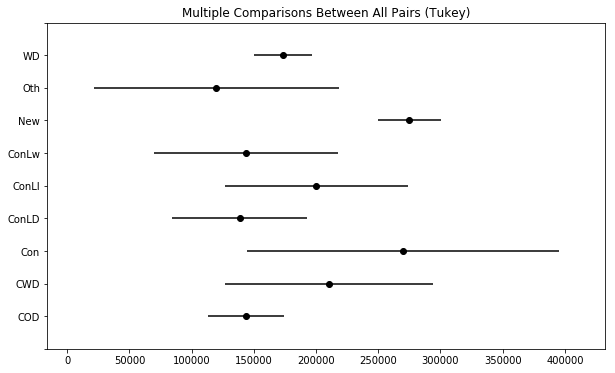

In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd
tukey_results = pairwise_tukeyhsd(ds_dropped["SalePrice"], ds_dropped["SaleType"])
tukey_results.plot_simultaneous()
tukey_results.summary()

Yes-- there are some sale types that do affect sale price. 

Specifically, there are differences between COD and New, ConLD and New, ConLw and New, New and Oth, and New and WD.

Let's dig further. It seems like New is involved in each of these.

In [16]:
from scipy.stats import f_oneway
# for st in df.groupby("SaleType"):
samples = [st[1] for st in ds_dropped[ds_dropped.SaleType != "New"].groupby("SaleType")["SalePrice"]]
f_result = f_oneway(*samples)
print(f_result)

F_onewayResult(statistic=2.4910442869728096, pvalue=0.015236514020208038)


group1,group2,meandiff,lower,upper,reject
COD,CWD,66626.7442,-45617.5257,178871.014,False
COD,Con,125626.7442,-29696.5186,280950.007,False
COD,ConLD,-5192.3669,-83901.5968,73516.8629,False
COD,ConLI,56416.7442,-45039.9862,157873.4746,False
COD,ConLw,-273.2558,-101729.9862,101183.4746,False
COD,Oth,-24123.2558,-152345.5474,104099.0358,False
COD,WD,29428.5808,-3867.4593,62724.6209,False
CWD,Con,59000.0,-126955.9613,244955.9613,False
CWD,ConLD,-71819.1111,-200851.8451,57213.6229,False
CWD,ConLI,-10210.0,-154250.8682,133830.8682,False


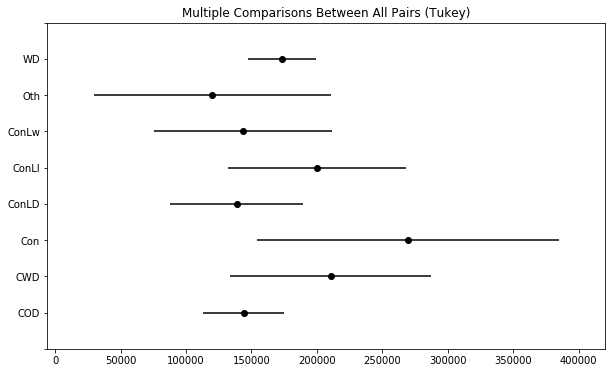

In [17]:
tukey_results = pairwise_tukeyhsd(ds_dropped[ds_dropped.SaleType != "New"]["SalePrice"], 
                                  ds_dropped[ds_dropped.SaleType != "New"]["SaleType"])
tukey_results.plot_simultaneous()
tukey_results.summary()

Significant F statistic, but non-significant post-hoc tests. This is possible. (why? simply because of family wise error correction?)

Now, we're not really interested in running f-tests with each of these values individually. We want to consider them together. We'll run a GLM, with dummy coding to take care of categorical variables.

In [13]:
# The following function does this:
print(ds_dropped.SaleType.unique())
pd.get_dummies(ds_dropped.SaleType).head()

['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']


,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
Id,,,,,,,,,
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,1


But, we don't want to dummy encode every categorical variable in case they occur with each other. Let's have a quick look at the covariance of the categorical features.

In [19]:
ds_dropped.loc[:, ds_dropped.dtypes == "object"].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [20]:
dummy_list = []
exclude = []
for c in ds_dropped.loc[:, ds_dropped.dtypes == "object"].columns:        
    dummy_list.append(pd.get_dummies(ds_dropped[c], prefix=c))
    exclude.append(c)
regression_df = pd.merge(ds_dropped.drop(exclude, axis=1), 
                         pd.concat(dummy_list, axis=1), on="Id")
regression_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


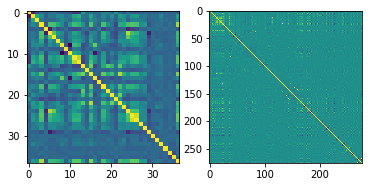

In [21]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(ds_dropped.drop(exclude, axis=1).corr())
axarr[1].imshow(regression_df.corr())

In [59]:
ds_dropped.drop(exclude, axis=1).corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


In [62]:
(ds_dropped.drop(exclude, axis=1).corr() > .8).sum()

# well interesting, these factors seem to be correlated...

MSSubClass       1
LotFrontage      1
LotArea          1
OverallQual      1
OverallCond      1
YearBuilt        2
YearRemodAdd     1
MasVnrArea       1
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      2
1stFlrSF         2
2ndFlrSF         1
LowQualFinSF     1
GrLivArea        2
BsmtFullBath     1
BsmtHalfBath     1
FullBath         1
HalfBath         1
BedroomAbvGr     1
KitchenAbvGr     1
TotRmsAbvGrd     2
Fireplaces       1
GarageYrBlt      2
GarageCars       2
GarageArea       2
WoodDeckSF       1
OpenPorchSF      1
EnclosedPorch    1
3SsnPorch        1
ScreenPorch      1
PoolArea         1
MiscVal          1
MoSold           1
YrSold           1
SalePrice        1
dtype: int64

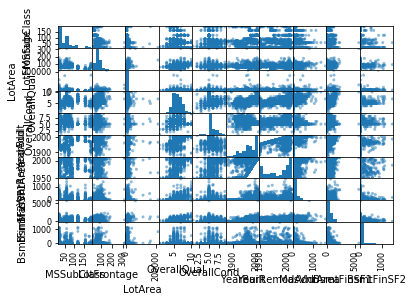

In [57]:
from pandas.plotting import scatter_matrix
axarr = scatter_matrix(ds_dropped.drop(exclude, axis=1).iloc[:, 0:10])

# this would make more sense with fewer predictors...

There is some collinearity, but not too bad

In [22]:
from statsmodels.api import OLS
results = OLS(regression_df.dropna()["SalePrice"], 
              regression_df.dropna().drop("SalePrice", axis=1)).fit()
print(results.summary())

/Users/njchiang/.pyenv/versions/kaggle/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/njchiang/.pyenv/versions/kaggle/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/njchiang/.pyenv/versions/kaggle/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/njchiang/.pyenv/versions/kaggle/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     54.51
Date:                Wed, 01 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:17:59   Log-Likelihood:                -12772.
No. Observations:                1121   AIC:                         2.600e+04
Df Residuals:                     892   BIC:                         2.715e+04
Df Model:                         228                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass               38.21

Woops! Collinearity is bad. That's because we dummy coded as K dummy codes, not K - 1.

In [23]:
dummy_list = []
categorical = []
interp_relative = {}  # for us to claim "over and above"
for c in ds_dropped.loc[:, ds_dropped.dtypes == "object"].columns:        
    dummy_trap_drop = ds_dropped[c].dropna().unique()[-1]
    dummy_list.append(pd.get_dummies(ds_dropped[c], prefix=c).drop("{}_{}".format(c, dummy_trap_drop), axis=1))
    categorical.append(c)
    interp_relative[c] = dummy_trap_drop
regression_df = pd.merge(ds_dropped.drop(categorical, axis=1), 
                         pd.concat(dummy_list, axis=1), on="Id")
regression_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,1,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


In [24]:
results = OLS(regression_df.dropna()["SalePrice"], 
              regression_df.dropna().drop("SalePrice", axis=1)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     55.62
Date:                Wed, 01 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:18:07   Log-Likelihood:                -12773.
No. Observations:                1121   AIC:                         2.600e+04
Df Residuals:                     896   BIC:                         2.713e+04
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass               39.42

In [25]:
sig_predictors = list((results.pvalues < .05).index)

That's a lot! There are several ways to determine the "most important ones", one of which is looking at variance lost when removing it from the model. We also seem to still have a collinearity problem. 

In [26]:
categorical + ["SalePrice"]

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'SalePrice']

In [30]:
# Let's look at continuous variables first

results = OLS(ds_dropped.drop(categoical, axis=1).dropna()["SalePrice"], 
              ds_dropped.drop(categorical, axis=1).dropna().drop("SalePrice", axis=1)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     975.0
Date:                Tue, 31 Jul 2018   Prob (F-statistic):               0.00
Time:                        21:40:52   Log-Likelihood:                -13358.
No. Observations:                1121   AIC:                         2.678e+04
Df Residuals:                    1087   BIC:                         2.695e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass     -200.6082     34.465     -5.821

In [27]:
results = OLS(pd.concat(dummy_list, axis=1).join(ds_dropped["SalePrice"]).dropna()["SalePrice"], 
              pd.concat(dummy_list, axis=1).dropna()).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     254.9
Date:                Wed, 01 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:18:20   Log-Likelihood:                -17160.
No. Observations:                1460   AIC:                         3.472e+04
Df Residuals:                    1261   BIC:                         3.577e+04
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSZoning_C (all)      -5.416e+

In [ ]:
# practice bootstrap/jackknife/permutation

For S&G, we can train a machine learning classifier to do this:

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
train_df, test_df = train_test_split(regression_df)

In [70]:
rf = RandomForestRegressor(n_estimators=50, max_depth=5)
rf.fit(train_df.dropna().drop("SalePrice", axis=1),
       train_df.dropna()["SalePrice"])
rf.score(test_df.dropna().drop("SalePrice", axis=1),
         test_df.dropna()["SalePrice"])

0.8426079013634227

In [71]:
ols = LinearRegression()
ols.fit(train_df.dropna().drop("SalePrice", axis=1),
       train_df.dropna()["SalePrice"])
ols.score(test_df.dropna().drop("SalePrice", axis=1),
         test_df.dropna()["SalePrice"])

/Users/njchiang/.pyenv/versions/kaggle/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


0.7985094069434953